In [1]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing

# Airfoil

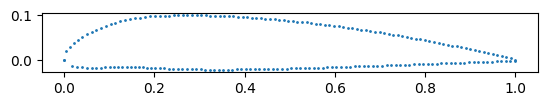

In [2]:
airfoil = af.Airfoil.NACA4("2412", n_points=100)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

alpha0 = -2 * np.pi / 180

# Polar Formulation

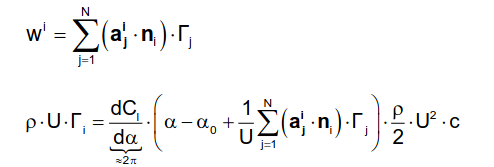

## Wing Geometry

In [3]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)

def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)

def logSpan(sp, Ni):
    return np.hstack((0,np.geomspace(1e-1, sp, Ni-1)))

def goodSpan(sp, Ni):
    epsilon = 1e-1
    Ni = int(Ni/2)
    left = np.geomspace(1e-3, sp/2 -epsilon, Ni)
    right = sp/2 + left
    left = sp/2 - left
    return np.hstack((left,right))

def sinSpan(sp, Ni):
    lin = np.linspace(0, np.pi/2, Ni)
    sin = np.sin(lin)
    return sin * sp


## Discretization and Grid Generation

In [4]:
N = 69
M = 2
%matplotlib qt
wg = Wing(
    airfoil=airfoil,
    isSymmetric=True,
    span=6,
    alpha=2,
    beta=0,
    Ni=N,
    Nj=M,
    sweepOffset=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)

## Wind

In [5]:
Umag = 16
dens = 1.2

## Solve

In [6]:
L, D, Gammas, w_ind = wg.solveWing(alpha0, Umag, dens, pot.hshoe2)

print(f"L:{L}\t|\tD:{D}")
print(f"CL:{L/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{D/(dens*(Umag**2)*wg.wingArea)}")


L:294.5556057272089	|	D:5.116715700026303
CL:0.1598066437322097	|	CD_ind:0.0027759959310038537


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Results')

ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, Gammas)
ax1.set_xlabel("span")
ax1.set_title("Gamma")
ax1.minorticks_on()
ax1.grid()

ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, (w_ind/Umag) * 180 / np.pi)
ax2.set_xlabel("span")
ax2.set_title("w_ind")
ax2.minorticks_on()
ax2.grid()
